Please select the tmp_xenium_publication_env to run this script

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from shapely.geometry import Polygon
from skimage.io import imread as skimread
from shapely import wkt
from companion_functions import (
    plot_polygons
)
from shapely.ops import unary_union

import scanpy as sc


In [2]:
polygons_xenium = '/srv/gstore/projects/p37785/Visium_HD_HLC_pXPE2_Xseg/nuclei_df.csv'

polygons_enact = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/cells_df.csv'

polygons_nuclei = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-07-04--15-13-09/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/nuclei_df.csv'

wsi_image_path = '/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/tmap/wsi.tif'

In [3]:

# Load the Visium full resolution image
wsi_image = skimread(wsi_image_path)


In [4]:
# Filter polygons to those that overlap the zoomed region
def polygon_in_crop(polygon, x_min, x_max, y_min, y_max):
    # polygon: (N,) array of interleaved x and y coordinates
    xs = polygon[::2]  # x coordinates are at even indices
    ys = polygon[1::2] # y coordinates are at odd indices
    return (
        (xs >= x_min).any() and (xs < x_max).any() and
        (ys >= y_min).any() and (ys < y_max).any()
    )

# Shift polygons so they match the crop region
def shift_polygon(polygon, x_min, y_min):
    shifted_polygon = polygon.copy()
    shifted_polygon[::2] -= x_min  # Subtract x_min from x coordinates
    shifted_polygon[1::2] -= y_min # Subtract y_min from y coordinates
    return shifted_polygon

In [5]:
xenium_cell_polygons = pd.read_csv(polygons_xenium)
enact_cell_polygons = pd.read_csv(polygons_enact)
nucleus_polygons = pd.read_csv(polygons_nuclei)
xenium_cell_polygons = xenium_cell_polygons.dropna(subset=['geometry'])
enact_cell_polygons = enact_cell_polygons.dropna(subset=['geometry'])
nucleus_polygons = nucleus_polygons.dropna(subset=['geometry'])

xenium_cell_polygons["parsed_geometry"] = xenium_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
xenium_cell_polygons["parsed_coordinates"] = xenium_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

enact_cell_polygons["parsed_geometry"] = enact_cell_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
enact_cell_polygons["parsed_coordinates"] = enact_cell_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

nucleus_polygons["parsed_geometry"] = nucleus_polygons["geometry"].apply(wkt.loads)
# Convert parsed_geometry to list of arrays with alternating x and y values
nucleus_polygons["parsed_coordinates"] = nucleus_polygons["parsed_geometry"].apply(
    lambda geom: np.array(geom.exterior.coords).flatten()
)

xenium_polygons = xenium_cell_polygons["parsed_coordinates"].to_numpy()

enact_polygons = enact_cell_polygons["parsed_coordinates"].to_numpy()

nucleus_polygons = nucleus_polygons["parsed_coordinates"].to_numpy()

# Compute centers for Xenium polygons
xenium_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in xenium_polygons
])

# Compute centers for ENACT polygons
enact_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in enact_polygons
])

# Compute centers for nucleus polygons
nucleus_centers = np.array([
    np.mean(poly.reshape(-1, 2), axis=0) for poly in nucleus_polygons
])

In [6]:
crop_size = 197
x_min, y_min = 2000, 2000  # Starting coordinates for the crop
x_max,y_max = x_min + crop_size, y_min + crop_size  # Ending coordinates for the crop

In [7]:

xenium_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in xenium_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

enact_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in enact_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]

nucleus_crop_polygons = [
    shift_polygon(poly, x_min, y_min).reshape(-1, 2) for poly in nucleus_polygons
    if polygon_in_crop(poly, x_min, x_max, y_min, y_max)
]   


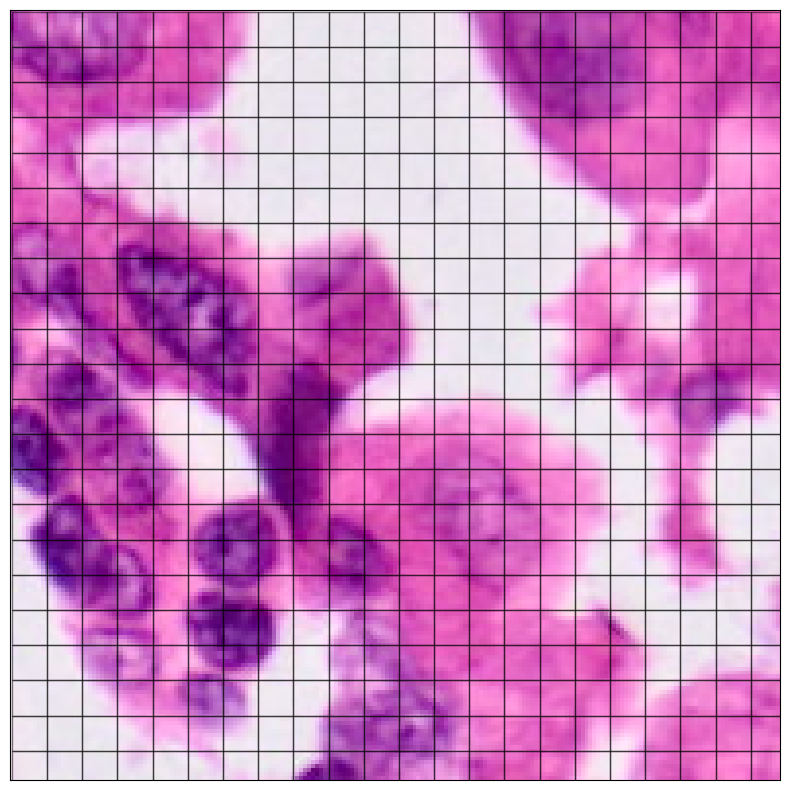

In [8]:
# Calculate the size of 8um in pixels
um_size = 2
pixel_size_um = 4.7  # pixels per 1um
square_size_px = int(round(um_size * pixel_size_um))

fig, ax = plt.subplots(figsize=(8, 8))
# Show the crop region of the WSI image
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

# Overlay 8um x 8um squares (space filling)
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [65]:
# colors
import seaborn as sns
palette = sns.color_palette("Set2", n_colors=5)
method_colors = {
    'Bin2Cell': palette[0],
    'ENACT': palette[1],
    'Xseg': palette[3],
    '16x16': palette[4],
    '8x8': palette[4],
} # same colors as for MECR plotting


set2_palette = sns.color_palette("Set2")

Start with the 8x8 bins

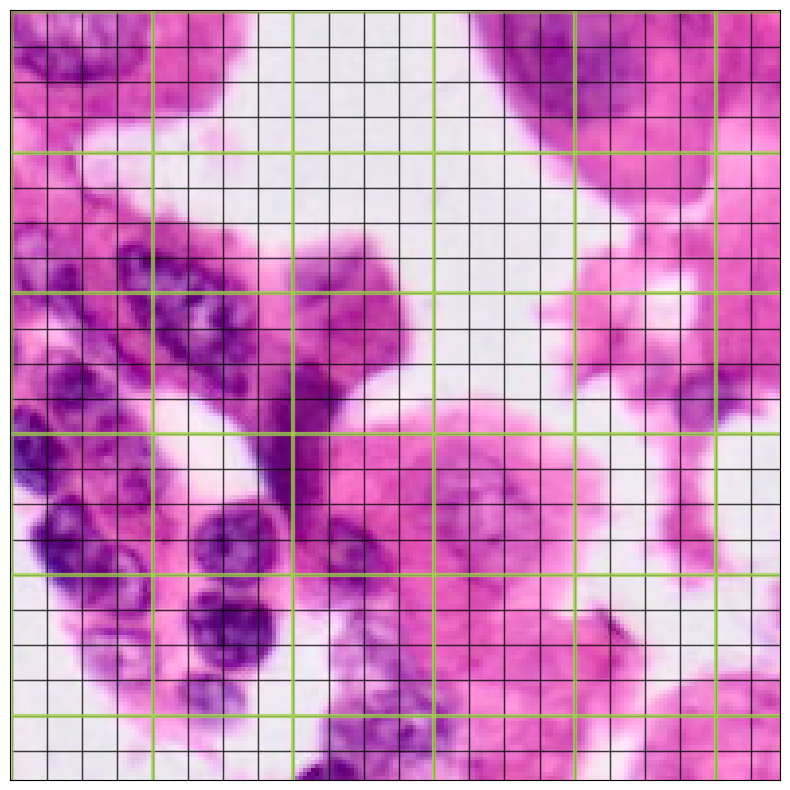

In [10]:
# Calculate the size of 8um in pixels
um_size_8 = 7.6
pixel_size_um = 4.7  # pixels per 1um
square_size_px_8 = int(round(um_size_8 * pixel_size_um))

fig, ax = plt.subplots(figsize=(8, 8))
# Show the crop region of the WSI image
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

# Overlay 2um x 2um squares (space filling)
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)# Overlay 8um x 8um squares (space filling)

for i in range(0, crop_size, square_size_px_8):
    for j in range(0, crop_size, square_size_px_8):
        rect = plt.Rectangle(
            (i, j),
            square_size_px_8,
            square_size_px_8,
            linewidth=3.0,
            edgecolor=method_colors['8x8'],
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

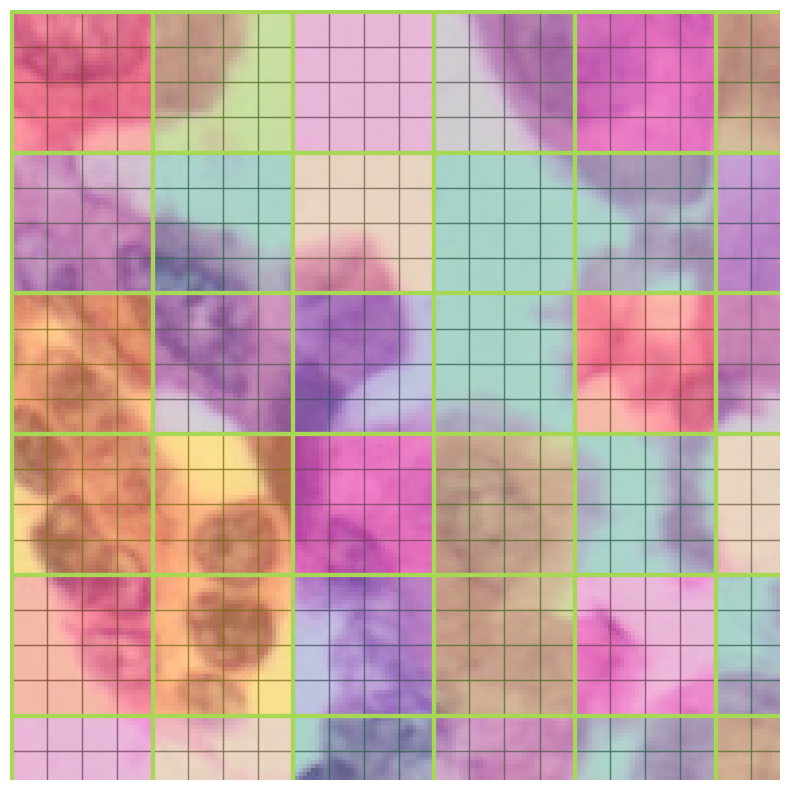

In [66]:
import random

# Calculate the size of 8um in pixels
um_size_8 = 7.6
pixel_size_um = 4.7  # pixels per 1um
square_size_px_8 = int(round(um_size_8 * pixel_size_um))

fig, ax = plt.subplots(figsize=(8, 8))
# Show the crop region of the WSI image
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

# Overlay 2um x 2um squares (space filling)
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)# Overlay 8um x 8um squares (space filling)
for i in range(0, crop_size, square_size_px_8):
    for j in range(0, crop_size, square_size_px_8):
        # Slightly vary the facecolor by adjusting the alpha and brightness
        base_color = np.array(method_colors['8x8'])
        # Randomly vary brightness by up to ±10%
        # Slightly vary the color itself by adding a small random value to each channel
        varied_color = set2_palette[np.random.randint(0, len(set2_palette))]
        # Randomly vary alpha between 0.1 and 0.2
        alpha = 0.5
        rect = plt.Rectangle(
            (i, j),
            square_size_px_8,
            square_size_px_8,
            linewidth=3.0,
            edgecolor=method_colors['8x8'],
            facecolor=(*varied_color, alpha),
        )
        ax.add_patch(rect)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.tight_layout()
plt.show()

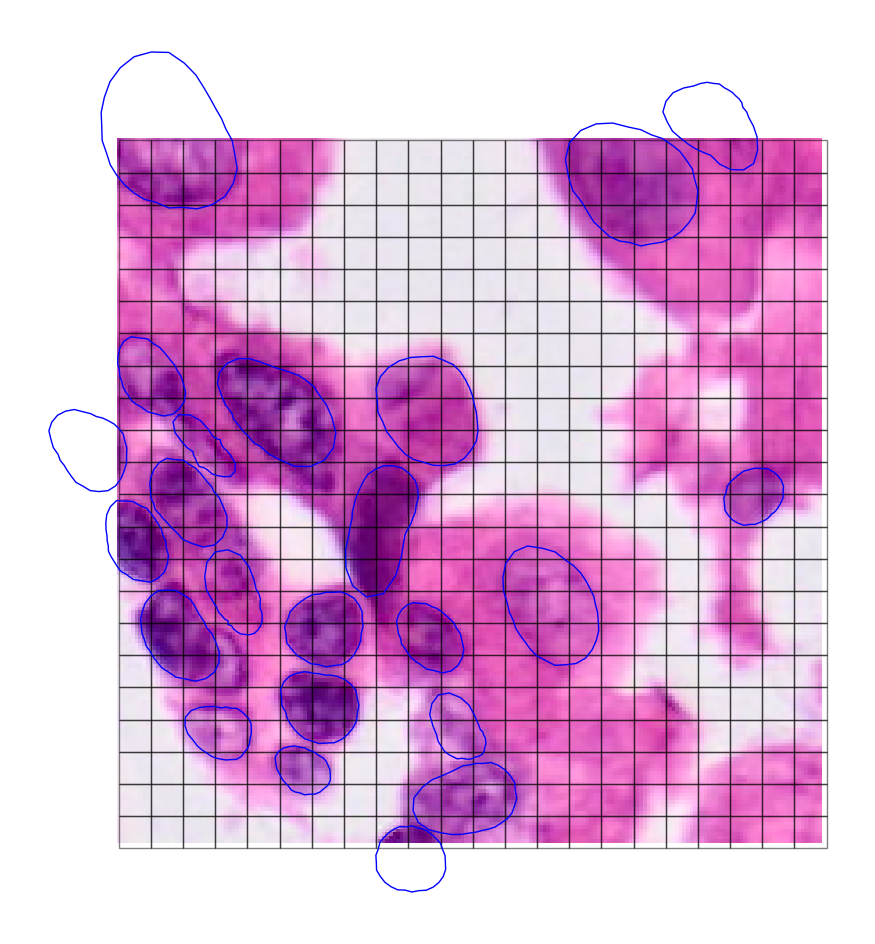

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)

for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)

plot_polygons(
    nucleus_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="Green",
    linewidth=3,
)
ax.set_xlim(0, crop_size)
ax.set_ylim(0, crop_size)
# Plot style adjustments

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

Bin2Cell

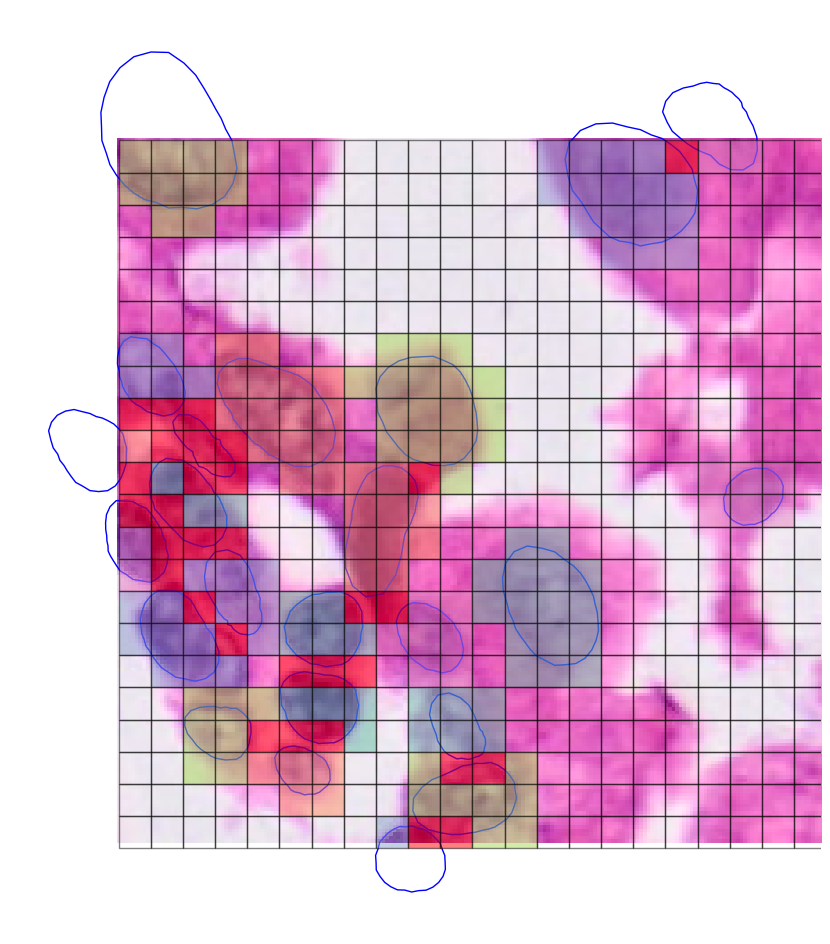

In [51]:
from shapely.geometry import box

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()


# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)

plot_polygons(
    nucleus_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="Green",
    linewidth=1,
)

# For each square, check overlap with any nucleus polygon
box_labels = []  # Will store either list of indices, "red", or "empty" for each box
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        square_poly = box(i, j, i + square_size_px, j + square_size_px)
        overlapping_indices = [
            idx for idx, nuc_poly in enumerate(nucleus_crop_polygons)
            if Polygon(nuc_poly).intersects(square_poly)
        ]
        if overlapping_indices:
            if len(overlapping_indices) > 1:
                color = "red"
                box_labels.append("red")
            else:
                color = palette[overlapping_indices[0] % len(palette)]
                box_labels.append(overlapping_indices)
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor=color,
                alpha=0.5
            )
            ax.add_patch(rect)
        else:
            box_labels.append("empty")
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor='none',
                alpha=0.5
            )
            ax.add_patch(rect)


# Plot style adjustments
ax.set_xlim(0, crop_size)
ax.set_ylim(0, crop_size)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

In [38]:
import numpy as np

# Helper to get box centers
def get_box_centers(crop_size, square_size_px):
    centers = []
    for i in range(0, crop_size, square_size_px):
        for j in range(0, crop_size, square_size_px):
            centers.append((i + square_size_px / 2, j + square_size_px / 2))
    return np.array(centers)

# Build box grid and initial labels
box_centers = get_box_centers(crop_size, square_size_px)
num_boxes = len(box_centers)
labels = np.array(box_labels, dtype=object)
d = 17  # maximum distance to propagate labels

labeled_indices = [i for i, l in enumerate(labels) if l != "empty"]


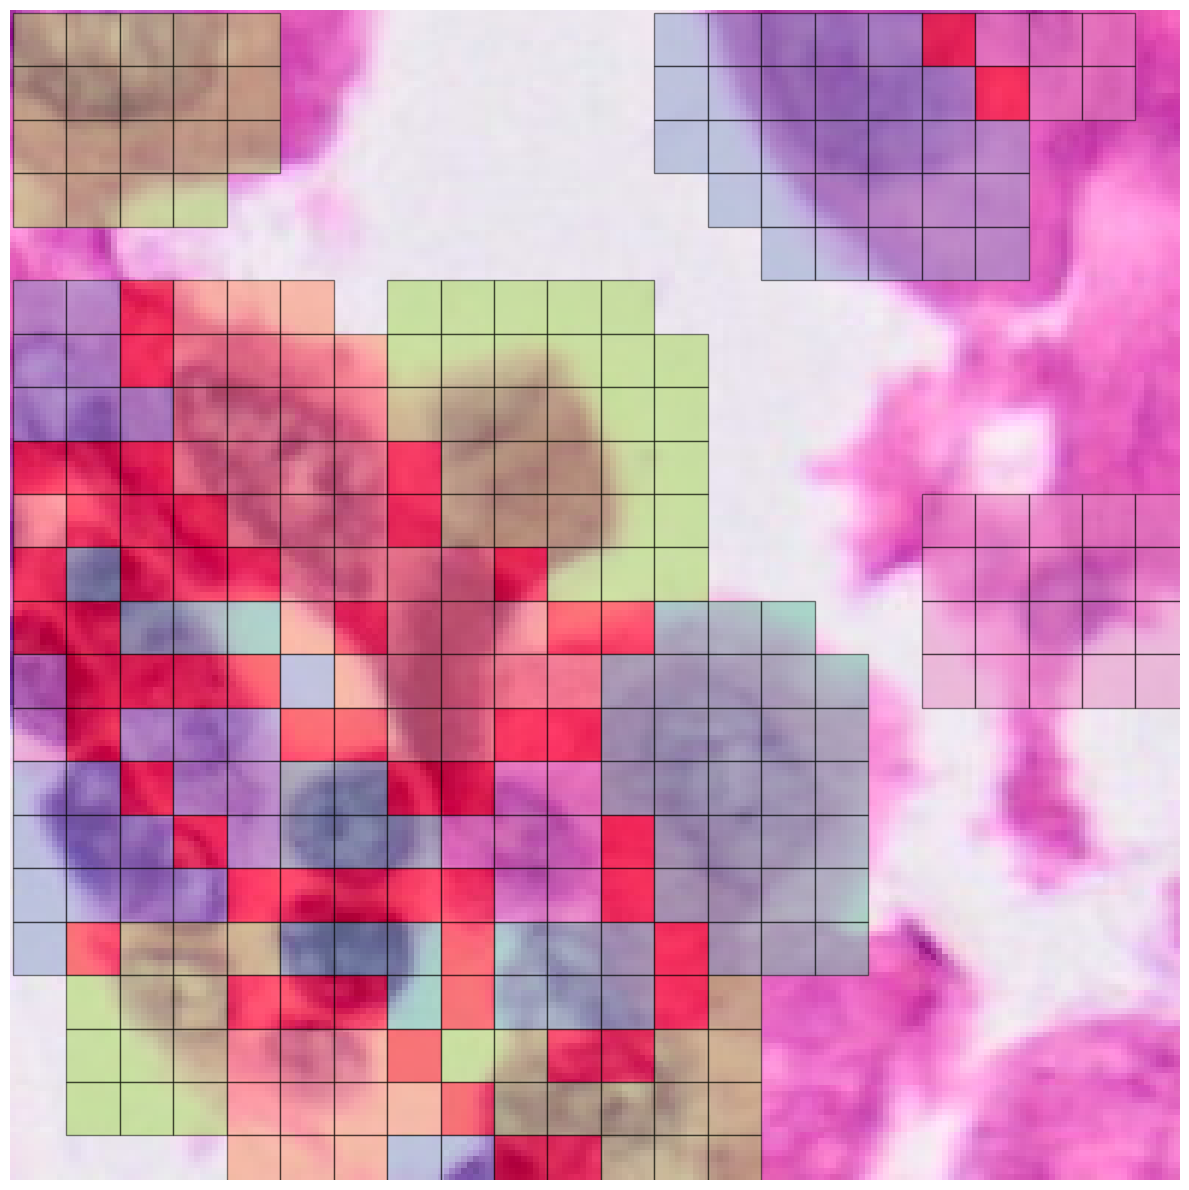

In [40]:

for idx in range(num_boxes):
    if labels[idx] == "empty":
        dists = np.linalg.norm(box_centers[labeled_indices] - box_centers[idx], axis=1)
        min_dist = np.min(dists)
        if min_dist > d:
            continue  # leave as "empty"
        closest = [labeled_indices[i] for i, dist in enumerate(dists) if np.isclose(dist, min_dist)]
        # If equidistant to multiple with different labels, color red
        closest_labels = set([str(labels[c]) for c in closest])
        if len(closest_labels) > 1:
            labels[idx] = "red"
        else:
            labels[idx] = labels[closest[0]]

# Plot
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.imshow(wsi_image[y_min:y_max, x_min:x_max])

for idx, (center, label) in enumerate(zip(box_centers, labels)):
    i = int(center[0] - square_size_px / 2)
    j = int(center[1] - square_size_px / 2)
    if label == "red":
        color = "red"
    elif label == "empty":
        color = "none"
    elif isinstance(label, list):
        color = palette[label[0] % len(palette)]
    else:
        color = palette[0] if label == "Bin2Cell" else "none"
    rect = plt.Rectangle(
        (i, j),
        square_size_px,
        square_size_px,
        linewidth=1.0,
        edgecolor='Black',
        facecolor=color,
        alpha=0.5 if color != "none" else 0
    )
    ax.add_patch(rect)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.tight_layout()
plt.show()

# ENACT

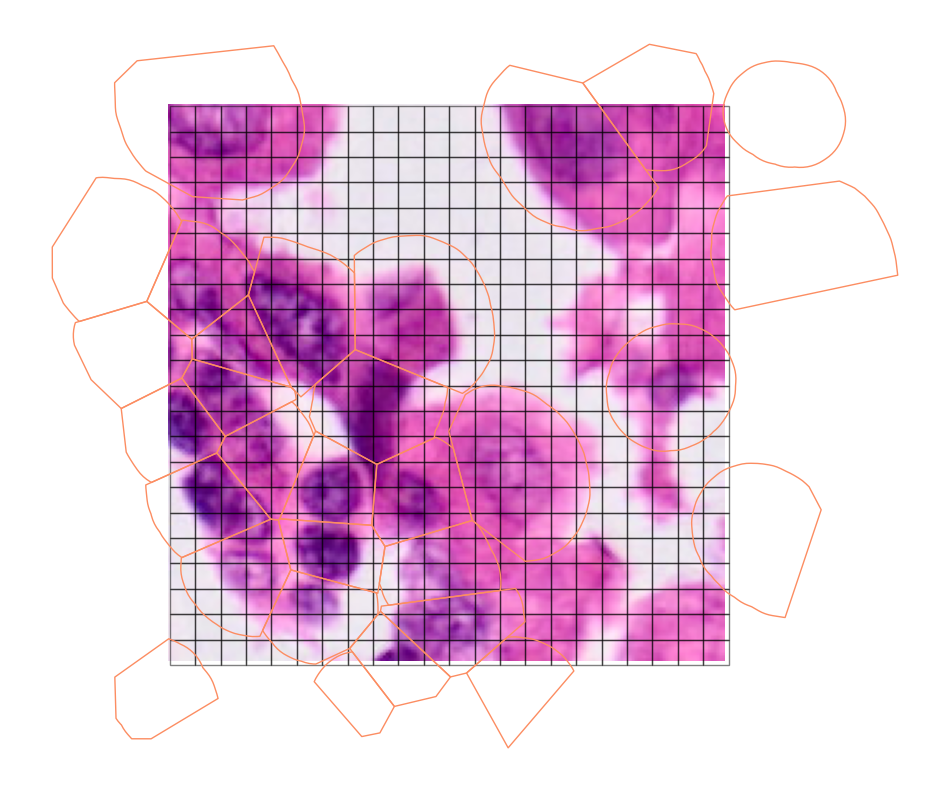

In [42]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)

for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        ax.add_patch(rect)

plot_polygons(
    enact_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor=method_colors['ENACT'],
    linewidth=3,
)

# Plot style adjustments
ax.set_xlim(0, crop_size)
ax.set_ylim(0, crop_size)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

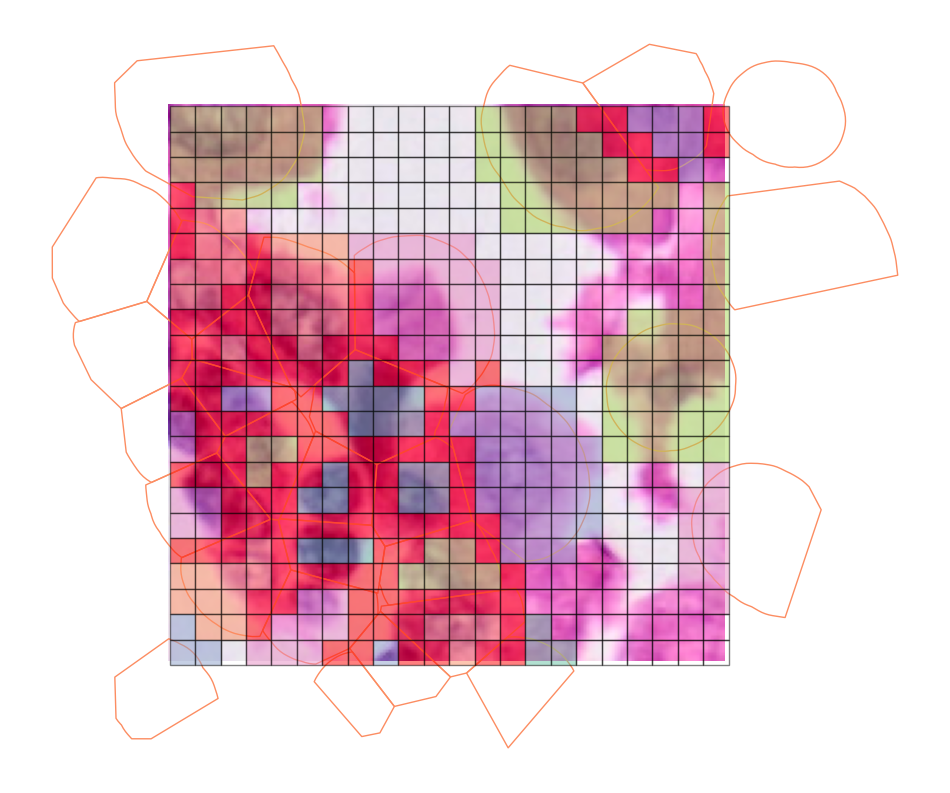

In [44]:
from shapely.geometry import box

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)

plot_polygons(
    enact_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor=method_colors['ENACT'],
    linewidth=1,
)

# For each square, check overlap with any enact polygon
box_labels = []  # Will store either list of indices, "red", or "empty" for each box
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        square_poly = box(i, j, i + square_size_px, j + square_size_px)
        overlapping_indices = [
            idx for idx, enact_poly in enumerate(enact_crop_polygons)
            if Polygon(enact_poly).intersects(square_poly)
        ]
        if overlapping_indices:
            if len(overlapping_indices) > 1:
                color = "red"
                box_labels.append("red")
            else:
                color = palette[overlapping_indices[0] % len(palette)]
                box_labels.append(overlapping_indices)
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor=color,
                alpha=0.5
            )
            ax.add_patch(rect)
        else:
            box_labels.append("empty")
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor='none',
                alpha=0.5
            )
            ax.add_patch(rect)


# Plot style adjustments
ax.set_xlim(0, crop_size)
ax.set_ylim(0, crop_size)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

# Xenium segmentation

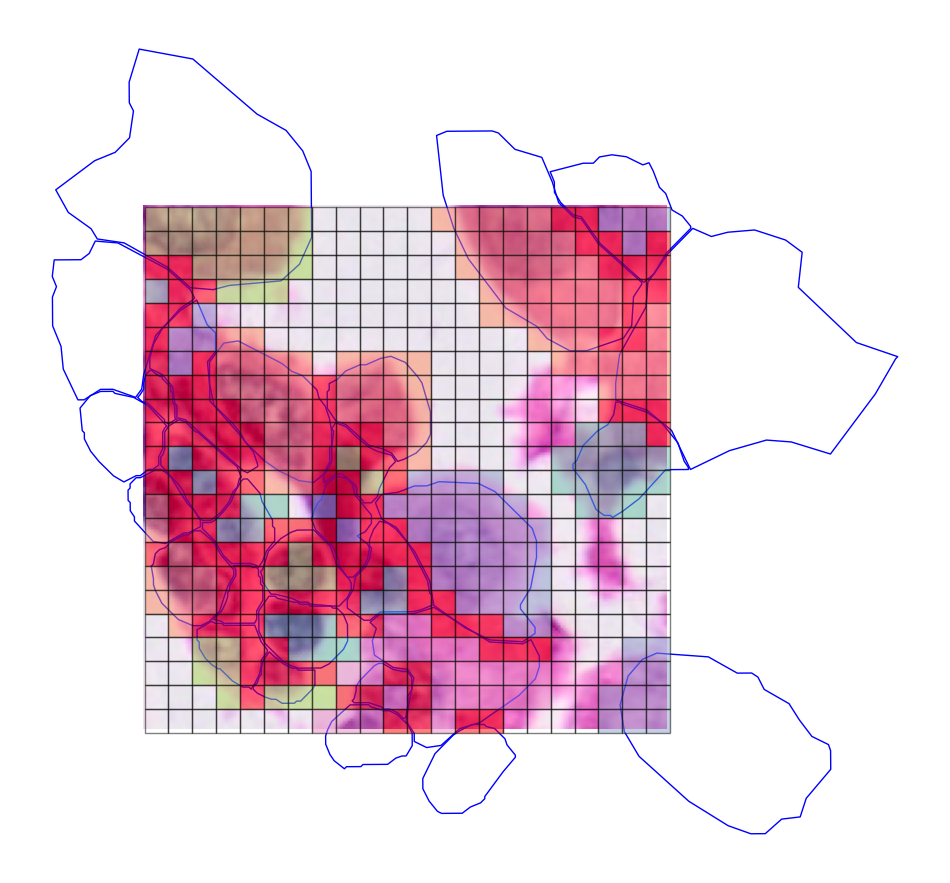

In [45]:
from shapely.geometry import box

fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)

plot_polygons(
    xenium_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor=method_colors['Xseg'],
    linewidth=1,
)

# For each square, check overlap with any xenium polygon
box_labels = []  # Will store either list of indices, "red", or "empty" for each box
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        square_poly = box(i, j, i + square_size_px, j + square_size_px)
        overlapping_indices = [
            idx for idx, xenium_poly in enumerate(xenium_crop_polygons)
            if Polygon(xenium_poly).intersects(square_poly)
        ]
        if overlapping_indices:
            if len(overlapping_indices) > 1:
                color = "red"
                box_labels.append("red")
            else:
                color = palette[overlapping_indices[0] % len(palette)]
                box_labels.append(overlapping_indices)
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor=color,
                alpha=0.5
            )
            ax.add_patch(rect)
        else:
            box_labels.append("empty")
            rect = plt.Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor='none',
                alpha=0.5
            )
            ax.add_patch(rect)


# Plot style adjustments
ax.set_xlim(0, crop_size)
ax.set_ylim(0, crop_size)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

In [75]:
import pickle

# Load labels_list from file
with open("labels_list.pkl", "rb") as f:
    loaded_labels_list = pickle.load(f)


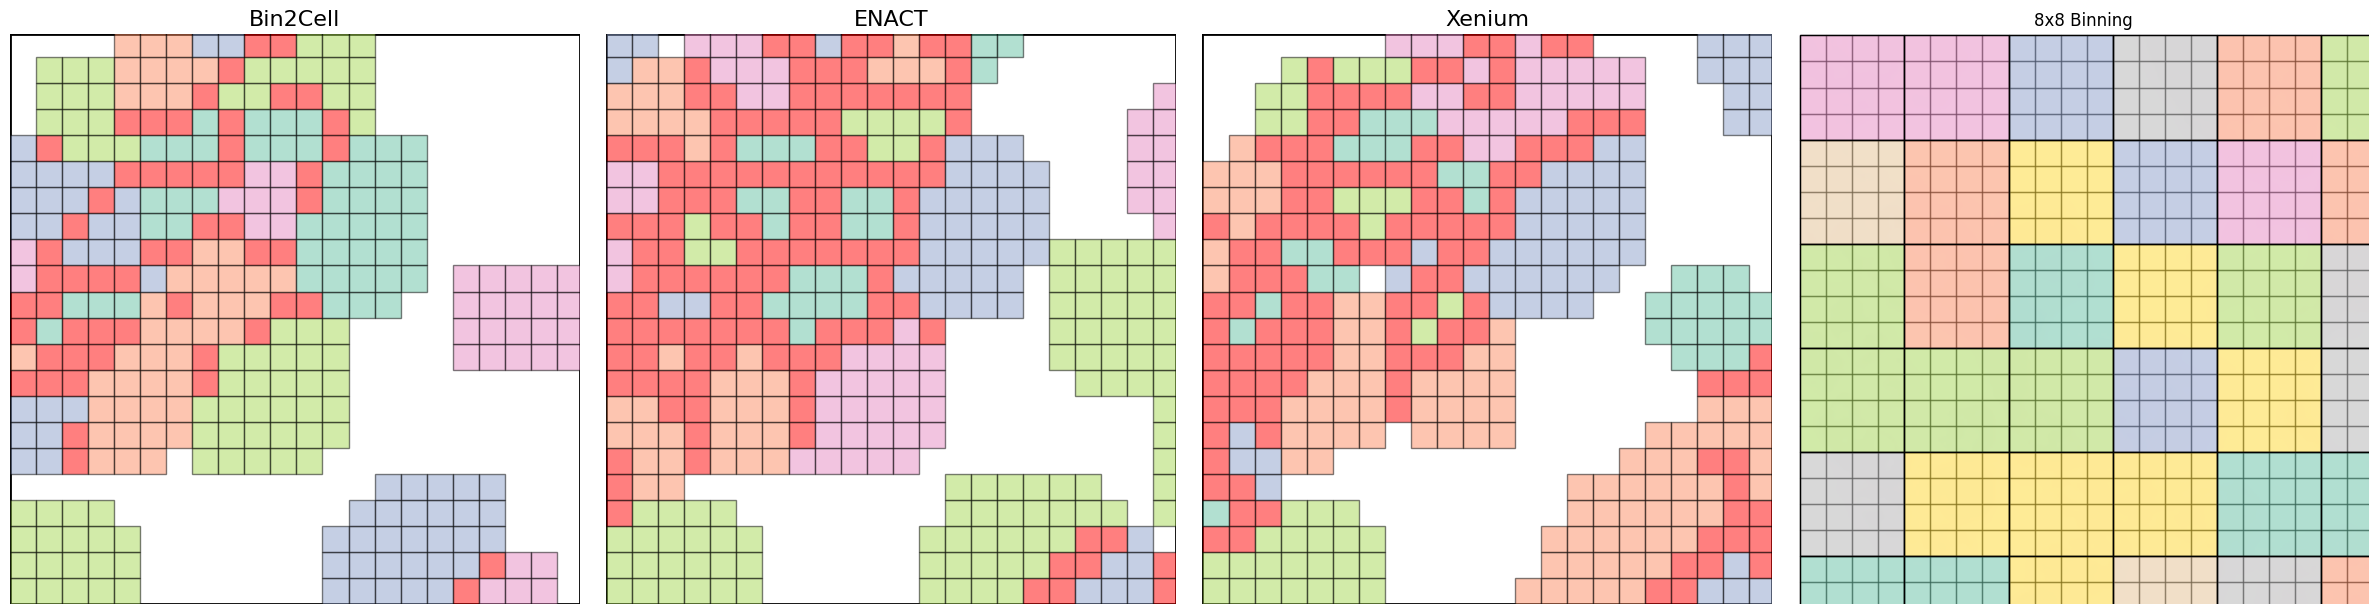

In [74]:
from matplotlib.patches import Rectangle, Polygon as MplPolygon

# Prepare method display names and colors
methods = ['Bin2Cell', 'ENACT', 'Xseg']

method_display_names = {
    'Bin2Cell': 'Bin2Cell',
    'ENACT': 'ENACT',
    'Xseg': 'Xenium'
}

# Use the labels_list and methods variables already defined
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for ax, method, method_labels in zip(axes, methods, loaded_labels_list):
    ax.set_title(method_display_names.get(method, method), fontsize=16)
    # Draw crop boundary
    crop_boundary = MplPolygon(
        [[0, 0], [crop_size, 0], [crop_size, crop_size], [0, crop_size]],
        closed=True, fill=False, edgecolor='black', linewidth=2
    )
    ax.add_patch(crop_boundary)
    # Draw squares
    idx = 0
    for i in range(0, crop_size, square_size_px):
        for j in range(0, crop_size, square_size_px):
            label = method_labels[idx]
            if label == "red":
                color = "red"
                alpha = 0.5
            elif label == "empty":
                color = "none"
                alpha = 0
            elif isinstance(label, list):
                color = palette[label[0] % len(palette)]
                alpha = 0.5
            else:
                color = palette[0]
                alpha = 0.5
            rect = Rectangle(
                (i, j),
                square_size_px,
                square_size_px,
                linewidth=1.0,
                edgecolor='Black',
                facecolor=color,
                alpha=alpha
            )
            ax.add_patch(rect)
            idx += 1
    ax.set_xlim(0, crop_size)
    ax.set_ylim(0, crop_size)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

axes[3].imshow(wsi_image[y_min:y_max, x_min:x_max], alpha=0.02)
# Overlay 2um x 2um squares (space filling)
for i in range(0, crop_size, square_size_px):
    for j in range(0, crop_size, square_size_px):
        rect = plt.Rectangle(
            (i, j),
            square_size_px,
            square_size_px,
            linewidth=1.0,
            edgecolor='Black',
            facecolor='none',
            alpha=0.5
        )
        axes[3].add_patch(rect)# Overlay 8um x 8um squares (space filling)
for i in range(0, crop_size, square_size_px_8):
    for j in range(0, crop_size, square_size_px_8):
        # Slightly vary the facecolor by adjusting the alpha and brightness
        base_color = np.array(method_colors['8x8'])
        # Randomly vary brightness by up to ±10%
        # Slightly vary the color itself by adding a small random value to each channel
        varied_color = set2_palette[np.random.randint(0, len(set2_palette))]
        # Randomly vary alpha between 0.1 and 0.2
        alpha = 0.5
        rect = plt.Rectangle(
            (i, j),
            square_size_px_8,
            square_size_px_8,
            linewidth=1.0,
            edgecolor='black',
            facecolor=(*varied_color, alpha),
        )
        axes[3].add_patch(rect)

axes[3].set_aspect("equal")
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].axis('off')

axes[3].title.set_text('8x8 Binning')


plt.tight_layout()
plt.show()

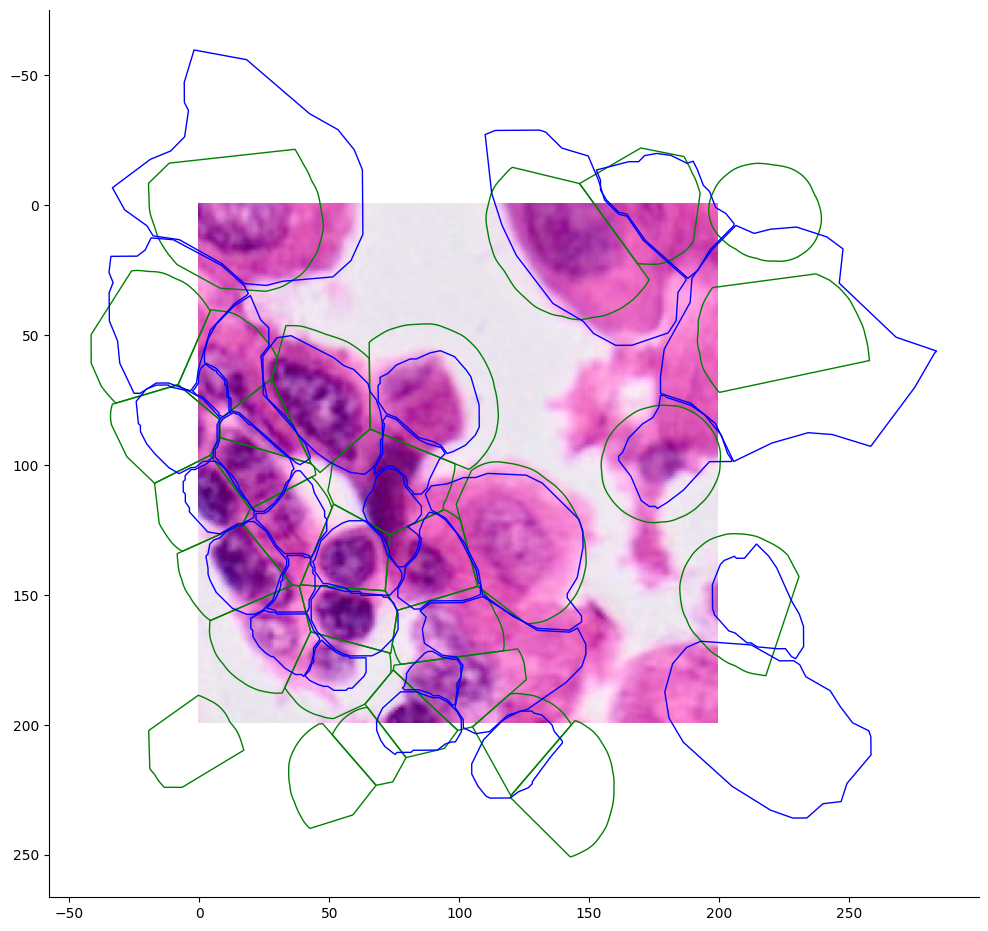

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = plt.gca()

# Show zoomed region of the full resolution image
ax.imshow(
    wsi_image[y_min:y_max, x_min:x_max]
)
plot_polygons(
    enact_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="green",
    linewidth=1,
)

plot_polygons(
    xenium_crop_polygons,
    ax=ax,
    facecolor=(0, 0, 0, 0),
    edgecolor="blue",
    linewidth=1,
)

# Plot style adjustments
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.set_aspect("equal", adjustable="box")

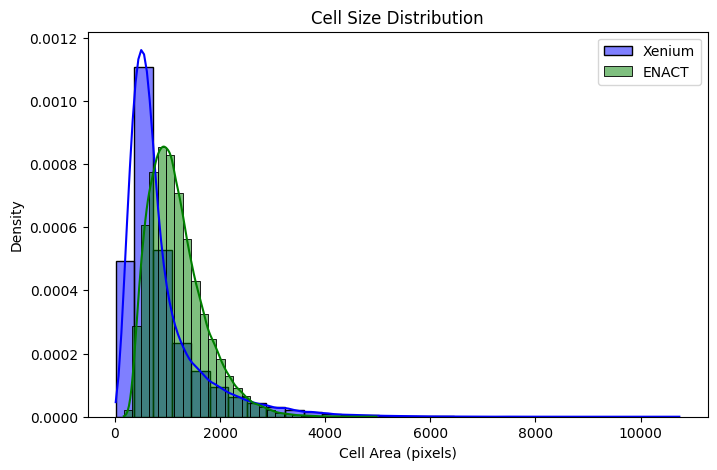

In [ ]:
import seaborn as sns

# Calculate areas
xenium_areas = [Polygon(poly).area for poly in xenium_polygons]
enact_areas = [Polygon(poly).area for poly in enact_polygons]

plt.figure(figsize=(8, 5))
sns.histplot(xenium_areas, color="blue", label="Xenium", kde=True, stat="density", bins=30, alpha=0.5)
sns.histplot(enact_areas, color="green", label="ENACT", kde=True, stat="density", bins=30, alpha=0.5)
plt.xlabel("Cell Area (pixels)")
plt.ylabel("Density")
plt.title("Cell Size Distribution")
plt.legend()
plt.show()

In [13]:
from shapely.geometry import Polygon

# Compute areas in pixels for ENACT and Xenium
enact_areas = [Polygon(poly).area for poly in enact_polygons]
xenium_areas = [Polygon(poly).area for poly in xenium_polygons]

# Mean and median in pixels
enact_mean_area_px = np.mean(enact_areas)
enact_median_area_px = np.median(enact_areas)
xenium_mean_area_px = np.mean(xenium_areas)
xenium_median_area_px = np.median(xenium_areas)

print(f"ENACT mean area: {enact_mean_area_px:.2f} px, median area: {enact_median_area_px:.2f} px")
print(f"Xenium mean area: {xenium_mean_area_px:.2f} px, median area: {xenium_median_area_px:.2f} px")

# Conversion to um^2 (replace PIXEL_SIZE_UM with your value)
PIXEL_SIZE_UM = 4.7  # placeholder, update with your pixel size in microns
enact_mean_area_um2 = enact_mean_area_px / (PIXEL_SIZE_UM ** 2)
enact_median_area_um2 = enact_median_area_px / (PIXEL_SIZE_UM ** 2)
xenium_mean_area_um2 = xenium_mean_area_px / (PIXEL_SIZE_UM ** 2)
xenium_median_area_um2 = xenium_median_area_px / (PIXEL_SIZE_UM ** 2)

print(f"ENACT mean area: {enact_mean_area_um2:.2f} um^2, median area: {enact_median_area_um2:.2f} um^2")
print(f"Xenium mean area: {xenium_mean_area_um2:.2f} um^2, median area: {xenium_median_area_um2:.2f} um^2")

ENACT mean area: 1178.81 px, median area: 1080.04 px
Xenium mean area: 898.00 px, median area: 653.62 px
ENACT mean area: 53.36 um^2, median area: 48.89 um^2
Xenium mean area: 40.65 um^2, median area: 29.59 um^2


In [13]:
def compute_iou(poly1, poly2):
    """Compute IoU between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

def compute_dice(poly1, poly2):
    """Compute Dice coefficient between two shapely polygons."""
    inter = poly1.intersection(poly2).area
    return 2 * inter / (poly1.area + poly2.area) if (poly1.area + poly2.area) > 0 else 0


In [ ]:
# Combine all polygons into one for each segmentation
xenium_crop_union = unary_union([Polygon(poly) for poly in xenium_crop_polygons])
enact_crop_union = unary_union([Polygon(poly) for poly in enact_crop_polygons])

# Compute IoU and Dice for the combined segmentation
combined_iou = compute_iou(xenium_crop_union, enact_crop_union)
print(f"Combined IoU (crop): {combined_iou:.3f}")

combined_dice = compute_dice(xenium_crop_union, enact_crop_union)
print(f"Combined Dice (crop): {combined_dice:.3f}")

Combined IoU (crop): 0.636
Combined Dice (crop): 0.778


In [ ]:
havetime = False

In [ ]:
if havetime:
    # Combine all polygons into one for each segmentation
    xenium_union = unary_union([Polygon(poly) for poly in xenium_polygons])
    enact_union = unary_union([Polygon(poly) for poly in enact_polygons])

    # Compute IoU and Dice for the combined segmentation
    combined_iou = compute_iou(xenium_union, enact_union)
    print(f"Combined IoU (all cells): {combined_iou:.3f}")

    combined_dice = compute_dice(xenium_union, enact_union)
    print(f"Combined Dice (all cells): {combined_dice:.3f}")

Combined IoU (all cells): 0.581
Combined Dice (all cells): 0.735


In [16]:
# Define the crop as a polygon
crop_poly = Polygon([
    (0, 0),
    (crop_size, 0),
    (crop_size, crop_size),
    (0, crop_size)
])

# Fraction of crop covered by each segmentation
xenium_frac = xenium_crop_union.area / crop_poly.area
enact_frac = enact_crop_union.area / crop_poly.area

print(f"Xenium: {xenium_frac:.3%} of crop area covered")
print(f"ENACT: {enact_frac:.3%} of crop area covered")

Xenium: 58.822% of crop area covered
ENACT: 81.391% of crop area covered


In [ ]:
full_poly = Polygon([
    (0,139),
    (1845, 139),
    (18456, 24480),
    (0, 24480)
])
if havetime:
    # Fraction of crop covered by each segmentation
    xenium_frac = xenium_union.area / full_poly.area
    enact_frac = enact_union.area / full_poly.area

    print(f"Xenium: {xenium_frac:.3%} of full area covered")
    print(f"ENACT: {enact_frac:.3%} of full area covered")

Xenium: 60.013% of full area covered
ENACT: 90.516% of full area covered
